<a href="https://colab.research.google.com/gist/proppy/26525ff7d9810247759a8d3ff3c41dcb/openlane-with-conda-eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenLane flow with conda-eda packages

```
Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

## install conda

In [2]:
!pip install -q condacolab
import condacolab
condacolab.install_from_url("https://repo.anaconda.com/miniconda/Miniconda3-py37_4.11.0-Linux-x86_64.sh")

⏬ Downloading https://repo.anaconda.com/miniconda/Miniconda3-py37_4.11.0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:26
🔁 Restarting kernel...


In [1]:
import condacolab
condacolab.check()
!sed -i -e /cudatoolkit/d /usr/local/conda-meta/pinned

✨🍰✨ Everything looks OK!


## Install dependencies

In [110]:
%%writefile environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  - open_pdks.sky130a
  - magic
  - openroad
  - netgen
  - yosys
  - gdstk
  - tcllib
  - python
  - pip
  - pip:
    - pyyaml
    - click
    - pandas

Overwriting environment.yml


In [105]:
!conda env update --prefix /usr/local --file environment.yml

Solving environment: / failed

ResolvePackageNotFound: 
  - openroad=2.0_3198



## Get OpenLane

In [107]:
!git clone --depth=1 https://github.com/The-OpenROAD-Project/OpenLane
!curl -L -O https://patch-diff.githubusercontent.com/raw/The-OpenROAD-Project/OpenLane/pull/1044.patch
!patch -d OpenLane -p1 < 1044.patch

fatal: destination path 'OpenLane' already exists and is not an empty directory.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1496    0  1496    0     0   7555      0 --:--:-- --:--:-- --:--:--  7555
patching file scripts/tcl_commands/floorplan.tcl


## Write verilog

In [16]:
%%writefile inverter.v
module inverter(input wire in, output wire out);
    assign out = !in;
endmodule

Overwriting inverter.v


## Write flow configuration

In [142]:
%%writefile flow.tcl

set ::env(DESIGN_NAME) inverter

set script_dir [file dirname [file normalize [info script]]]
set ::env(VERILOG_FILES) "$script_dir/inverter.v"

set ::env(CLOCK_TREE_SYNTH) 0
set ::env(CLOCK_PORT) ""

set ::env(PL_RANDOM_GLB_PLACEMENT) 1

set ::env(FP_SIZING) absolute
set ::env(DIE_AREA) "0 0 30 30"
set ::env(PL_TARGET_DENSITY) 0.75


set ::env(FP_PDN_HORIZONTAL_HALO) 6
set ::env(FP_PDN_VERTICAL_HALO) 6

set ::env(DIODE_INSERTION_STRATEGY) 3

# disable version checks because we use the latest packaged versions of open_pdks and OpenROAD
set ::env(TEST_MISMATCHES) none

Overwriting flow.tcl


## Run OpenLane Flow

- disable CVC because of https://github.com/hdl/conda-eda/issues/174
- disable klayout because of https://github.com/hdl/conda-eda/issues/175

In [143]:
import os
PATH=os.environ['PATH']
%env PDK_ROOT=/usr/local/share/pdk
%env TCLLIBPATH=/usr/local/lib/tcllib1.20
%env OPENLANE_ROOT=/content/OpenLane
%env PATH={PATH}:/content/OpenLane:/content/OpenLane/scripts
%env OPENLANE_LOCAL_INSTALL=1
!flow.tcl -design .

env: PDK_ROOT=/usr/local/share/pdk
env: TCLLIBPATH=/usr/local/lib/tcllib1.20
env: OPENLANE_ROOT=/content/OpenLane
env: PATH=/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLan

## Display layout

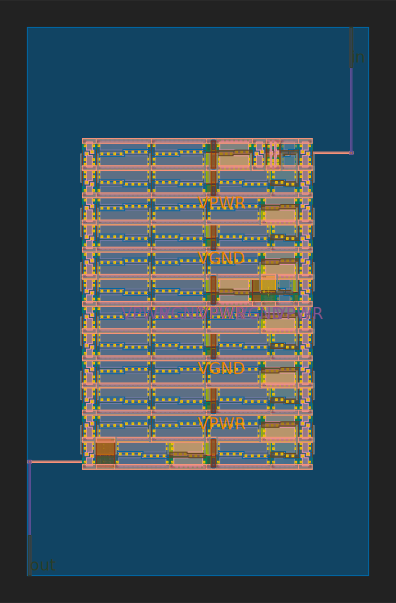

In [ ]:
import pathlib
import gdstk
from IPython.display import SVG

gdss = sorted(pathlib.Path('OpenLane/designs/inverter/runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[0])
top_cells = library.top_level()
top_cells[0].write_svg('inverter.svg')
SVG('inverter.svg')

## Dump flow report

In [148]:
import pandas as pd
import pathlib

final_summary_reports = sorted(pathlib.Path('/content/runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(final_summary_reports[-1])
pd.set_option('display.max_rows', None)
df.transpose()

,0
Unnamed: 0,0
design,/content
design_name,inverter
config,RUN_2022.04.12_06.20.14
flow_status,flow completed
total_runtime,0h0m33s0ms
routed_runtime,0h0m16s0ms
(Cell/mm^2)/Core_Util,-2.0
DIEAREA_mm^2,0.001925
CellPer_mm^2,-1


## Extract power metrics

In [149]:
def get_power(sta_power_report):
    with sta_power_report.open() as f:
        for l in f.readlines():
            if l.startswith('Total'):
                return float(l.split(' ')[-2])

def area_density_ppa():
    for report in sorted(pathlib.Path('/content/runs').glob('*/reports')):
        sta_power_report = report / 'signoff/27-rcx_sta.power.rpt'
        flow_report = report / 'metrics.csv'
        if flow_report.exists() and sta_power_report.exists():
            df = pd.read_csv(flow_report)
            power = get_power(sta_power_report)
            yield (df['DIEAREA_mm^2'][0], df['PL_TARGET_DENSITY'][0], power)

df = pd.DataFrame(area_density_ppa(), columns=('DIEAREA_mm^2', 'PL_TARGET_DENSITY', 'TOTAL_POWER'))
(df.style.hide_index()
   .format({'area': '{:.8f}', 'density': '{:.2%}', 'power': '{:.8f}'})
   .bar(subset=['TOTAL_POWER'], color='pink')
   .background_gradient(subset=['PL_TARGET_DENSITY'], cmap='Greens')
   .bar(color='lightblue', vmin=0.001, subset=['DIEAREA_mm^2']))

/content/runs/RUN_2022.04.12_06.08.59/reports/metrics.csv 0    0.001925
Name: DIEAREA_mm^2, dtype: float64
/content/runs/RUN_2022.04.12_06.18.46/reports/metrics.csv 0    0.001925
Name: DIEAREA_mm^2, dtype: float64
/content/runs/RUN_2022.04.12_06.20.14/reports/metrics.csv 0    0.001925
Name: DIEAREA_mm^2, dtype: float64


DIEAREA_mm^2,PL_TARGET_DENSITY,TOTAL_POWER
0.001925,0.750000,0.000001
0.001925,0.750000,0.000001
0.001925,0.750000,0.000001
